In [1]:
import pandas as pd
import numpy as np
import matplotlib.style as style
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab 
import random
import time
import datetime
import tqdm 
%matplotlib inline

In [3]:
flights_df = pd.read_csv("flights_2008.csv")

In [4]:
flights_df_without_unnecessary_columns = flights_df.drop(['Unnamed: 0', 'CRSDepTime', 'ArrTime', 'TailNum','CRSArrTime', 'FlightNum', 'AirTime', 'ActualElapsedTime', 'CRSElapsedTime', 'Cancelled', 'CancellationCode', 'Diverted', 'ArrDelay', 'TaxiIn', 'CarrierDelay','WeatherDelay','NASDelay', 'SecurityDelay', 'LateAircraftDelay', 'Dest'], axis=1)

In [139]:
#Fixing Departure times.
from datetime import datetime
departure_times = flights_df_without_unnecessary_columns['DepTime'].tolist()
str_departure_times = [str(int(time)) for time in departure_times]
years = [str(year) for year in flights_df_without_unnecessary_columns['Year'].tolist()]
months = [str(month) if month > 9 else '0'+ str(month) for month in flights_df_without_unnecessary_columns['Month'].tolist()]
days = [str(day) if day >9 else '0'+ str(day) for day in flights_df_without_unnecessary_columns['DayofMonth'].tolist()]
dates = []
for i in range(len(months)):
    dates.append(years[i]+"-"+months[i]+"-"+days[i])
hours_list = [time[0:-2] if time[0:-2] != ''  else '0' for time in str_departure_times]
minutes_list = [time[-2:] if len(time[-2:]) == 2 else '0'+time[-1] for time in str_departure_times]
departure_times_modified =[]
for i in range(len(hours_list)):
    departure_times_modified.append(hours_list[i]+minutes_list[i])    
fixed_hours = [time[0:-2] if len(time) == 4 else '0'+time[0:-2]  for time in departure_times_modified]
times = []
for i in range(len(fixed_hours)):
    times.append(fixed_hours[i]+":"+minutes_list[i])
times2 = [time if time != '24:00' else '00:00' for time in times] #STRING TIMES FINAL VERSION EVETYTHONG FIXED
date_and_time = []  #COMBINE DATE AND TIME TOGETHER
for i in range(len(dates)):
    date_and_time.append(times2[i]+" "+dates[i])
time_objects = []
for t in times2:
    time_objects.append(datetime.strptime(t, "%H:%M").time())   
flights_df_without_unnecessary_columns['DepTime'] = departure_times_modified #NOW DATE TIME IS ATIME OBJECT
flights_df_without_unnecessary_columns['DateTime'] = date_and_time

In [140]:
#TRANSFORM DATE AND TIME TO OBJECTS
date_times = flights_df_without_unnecessary_columns['DateTime'].tolist()
date_times_objects = []
for dt in date_times:
    date_times_objects.append(datetime.strptime(dt, "%H:%M %Y-%m-%d"))   
flights_df_without_unnecessary_columns['DateTime'] = date_times_objects

In [141]:
# Drop Na's
flights_df_withoutna = flights_df_without_unnecessary_columns.dropna()

In [142]:
#Filtering flights from ATL
atlanta_airport = flights_df_withoutna[flights_df_withoutna.eq('ATL').any(1)]
atlanta_airport_sorted = atlanta_airport.sort_values(by=['DateTime'])
atlanta_airport_sorted.drop(['Year', 'DayofMonth', 'Distance'], axis=1, inplace=True)
datetime_atl = [datetime for datetime in atlanta_airport_sorted['DateTime'].tolist()]
atl_differences = []
j = 0
for i in range(len(datetime_atl)-1):
    j = i + 1
    time_difference = atlanta_airport_sorted.iloc[j]['DateTime'] - atlanta_airport_sorted.iloc[i]['DateTime']
    int_time = int(time_difference.total_seconds()/60)
    atl_differences.append(int_time)

In [143]:
atl_differences.insert(0,0)

In [145]:
atl_queue_scores = [round((100/difference),3) if difference != 0 else 0 for difference in atl_differences]

In [146]:
atlanta_airport_sorted['QueueScores'] = atl_queue_scores

In [60]:
weather_df = pd.read_csv("atlanta_weather_2008.csv", sep = ";")

In [148]:
weather_df.sort_values(by=['DateTime'], inplace=True)

In [149]:
from datetime import datetime
datetimes_weather = weather_df['DateTime'].tolist()
datetimes_weather_objects = []
for dt in datetimes_weather:
    datetimes_weather_objects.append(datetime.strptime(dt, "%H:%M %Y-%m-%d"))
weather_df['DateTime'] = datetimes_weather_objects   

In [150]:
atlanta_taxiouts = atlanta_airport_sorted.copy()

In [61]:
#THIS CODE RUNS OVER 1.5 HOURS. THE RESULT CONVERTED TO CSV. FORMAT AND SAVED. IT CAN BE REACHED IN THE ZIP FILE.
#Combining weather condition indicators with the flights according to their time.
from tqdm import tqdm
temperature_list = []
pressure_list = []
humidity_list = []
wind_list = []
visibility_list = []
for i in tqdm(range(len(atlanta_taxiouts))):
    diff_min = 36000000000
    flight_time = atlanta_taxiouts.iloc[i]['DateTime']    
    for j in range(len(weather_df)):
        weather_time = weather_df.iloc[j]['DateTime']
        diff = abs(((weather_time - flight_time).total_seconds())/60)        
        if diff < diff_min:
            diff_min = diff
        else:
            break
    temperature_list.append(weather_df.iloc[j-1]['Temperature'])
    pressure_list.append(weather_df.iloc[j-1]['Pressure'])
    humidity_list.append(weather_df.iloc[j-1]['Humidity'] )
    wind_list.append(weather_df.iloc[j-1]['Wind'] )
    visibility_list.append(weather_df.iloc[j-1]['Visibility']) 

atlanta_taxiouts['Temperature'] = temperature_list
atlanta_taxiouts['Pressure'] = pressure_list
atlanta_taxiouts['Humidity'] = humidity_list
atlanta_taxiouts['Wind'] = wind_list
atlanta_taxiouts['Visibility'] = visibility_list
#atlanta_taxiouts.to_csv('atlanta_taxiout_weather_2008.csv')

100%|██████████| 131592/131592 [1:42:46<00:00, 21.34it/s]  


In [3]:
atlanta_data = pd.read_csv('atlanta_taxiout_weather_2008.csv')
atlanta_data.drop(['Unnamed: 0', 'DepDelay'], axis=1, inplace=True)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
#FIXING BROKEN DEPTIME FORMAT AGAIN
dep_time = atlanta_data['DepTime'].tolist()
dep_time_list = [str(int(time)) for time in dep_time]
hours_list = [time[0:-2] if time[0:-2] != ''  else '0' for time in dep_time_list]
minutes_list = [time[-2:] if len(time[-2:]) == 2 else '0'+time[-1] for time in dep_time_list]
final_dep_time =[]
for i in range(len(hours_list)):
    final_dep_time.append(hours_list[i]+minutes_list[i]) #do not use : to avoid mistake in gramming
atlanta_data['DepTime'] =  final_dep_time 

In [5]:
temperatures = [float(temperature.replace(',','.')) for temperature in atlanta_data['Temperature'].tolist()]
pressures = [float(pressure.replace(',','.')) for pressure in atlanta_data['Pressure'].tolist() ]
visibilities = [float(str(visibility).replace(',','.')) for visibility in atlanta_data['Visibility'].tolist()]
atlanta_data['Temperature'] = temperatures
atlanta_data['Pressure'] = pressures
atlanta_data['Visibility'] = visibilities

<AxesSubplot:xlabel='TaxiOut'>

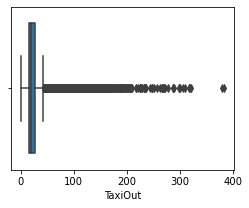

In [6]:
#sns.displot(atlanta_data, x="TaxiOut", binwidth=3, height =5, aspect=2 ) #Figure 2 Distribution of Taxi-Out Times
fig, ax = plt.subplots(figsize=(4,3)) 
sns.boxplot(x=atlanta_data["TaxiOut"]) # Figure 3 Box-Plot of Taxi-Out Times

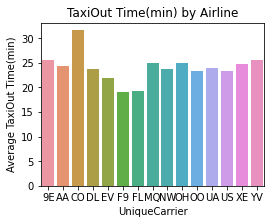

In [7]:
#Figure 4
carrier_grouped = atlanta_data.groupby(['UniqueCarrier'])['TaxiOut'].mean()
carrier_grouped = carrier_grouped.reset_index()
fig, ax = plt.subplots(figsize=(4,3)) 
ax = sns.barplot(x='UniqueCarrier', y='TaxiOut', data=carrier_grouped);
ax.set_title('TaxiOut Time(min) by Airline')
ax.set_ylabel('Average TaxiOut Time(min)');

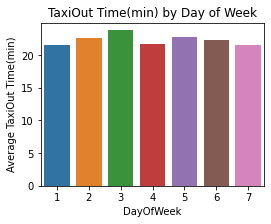

In [8]:
#Figure 5
day_grouped = atlanta_data.groupby(['DayOfWeek'])['TaxiOut'].mean()
day_grouped = day_grouped.reset_index()
fig, ax = plt.subplots(figsize=(4,3)) 
ax = sns.barplot(x='DayOfWeek', y='TaxiOut', data=day_grouped);
ax.set_title('TaxiOut Time(min) by Day of Week')
ax.set_ylabel('Average TaxiOut Time(min)');

In [9]:
#TAXIOUT TAGGING
taxiouts = atlanta_data['TaxiOut'].tolist()
taxiout_tags = ['Normal' if  taxiout <= 15 else  'Long'  for taxiout in taxiouts]
atlanta_taxiout_tagged= atlanta_data.copy()
atlanta_taxiout_tagged['TaxiOutCategory'] = taxiout_tags 

In [10]:
#SEASON TAGGING
months = atlanta_taxiout_tagged['Month'].tolist()
season_tags = ['Fall' if 9<= m <= 11 else 'Spring' if 3 <= m <= 5 else 'Summer' if  6<= m <= 8 else "Winter" for m in  months]
atlanta_seasons = atlanta_taxiout_tagged.copy()
atlanta_seasons['Season'] = season_tags

In [11]:
#DAY TIME PERIOD TAGGING
#Tagging Departure Time based on four categories 00:00-06:00 = T1, 06:00-12:00 = T2, 12:00-18:00=T3, 18:00-00:00=T4
deptimes = atlanta_seasons['DepTime'].tolist()
deptimes_tags = ['T1' if 0<= int(time[:-2]) <=5 else 'T2' if 6<= int(time[:-2])<=11 else 'T3' if 12<= int(time[:-2])<=17 else 'T4' for time in deptimes]
atlanta_deptime = atlanta_seasons.copy()
atlanta_deptime['TimeCategory'] = deptimes_tags 
atlanta_time_tagging = atlanta_deptime.drop(['Month', 'DepTime', 'DateTime'], axis = 1)
atlanta_time_tagging.reset_index(drop = True, inplace=True)

In [12]:
#Outlier Detection Tukey's Method
Q1 = atlanta_time_tagging['TaxiOut'].quantile(0.25)
Q3 = atlanta_time_tagging['TaxiOut'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 3 * IQR #upper bound
taxiouts = atlanta_time_tagging['TaxiOut'].tolist()
outlier_tags = [1 if taxiout  <= upper else -1 for taxiout in taxiouts]
outlier_detection = atlanta_time_tagging.copy()
outlier_detection['OutlierTag'] = outlier_tags 
cleaned_data = outlier_detection[(outlier_detection['OutlierTag'] == 1)]
str_dayofweek = [str(day) for day in cleaned_data['DayOfWeek'].tolist()]
atlanta_without_outliers = cleaned_data.copy()
atlanta_without_outliers['DayOfWeek'] = str_dayofweek 
atlanta_without_outliers
atlanta_outliers_removed = atlanta_without_outliers.copy()
atlanta_outliers_removed = atlanta_without_outliers[(atlanta_without_outliers['TaxiOut'] != 0)]

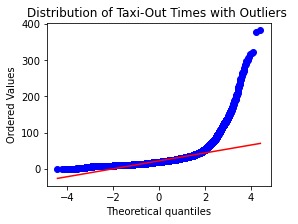

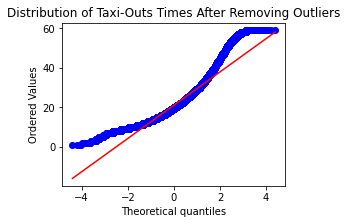

In [13]:
#Figure 6 and Figure 7 -Plotting the change after removing the outliers
fig, ax = plt.subplots(figsize=(4,3)) 
stats.probplot(atlanta_time_tagging['TaxiOut'].values, dist="norm", plot=pylab)
plt.title('Distribution of Taxi-Out Times with Outliers ')
pylab.show()
fig, ax = plt.subplots(figsize=(4,3)) 
stats.probplot(atlanta_outliers_removed['TaxiOut'].values, dist="norm", plot=pylab)
plt.title('Distribution of Taxi-Outs Times After Removing Outliers')
pylab.show()

In [14]:
atlanta_outliers_removed.drop(['OutlierTag'], axis=1, inplace= True)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


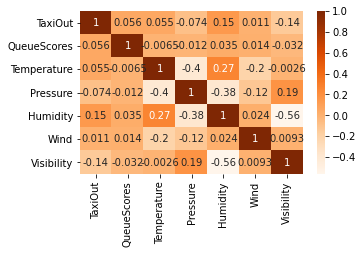

In [15]:
#Figure 8
plt.figure(figsize=(5,3))
cor = atlanta_outliers_removed.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Oranges )
plt.show()

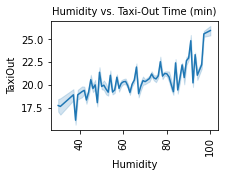

In [16]:
#Figure 9 -Humidity vs Taxi-Out Time
fig, ax = plt.subplots(figsize=(3,2)) 
sns.lineplot(x='Humidity', y='TaxiOut', data=atlanta_outliers_removed)
plt.xticks(rotation=90);
plt.title("Humidity vs. Taxi-Out Time (min)", size=10);

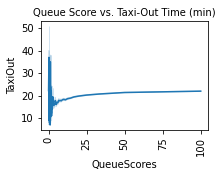

In [17]:
#Figure 10 - Visibility vs Taxi-Out Time
fig, ax = plt.subplots(figsize=(3,2)) 
sns.lineplot(x='QueueScores', y='TaxiOut', data=atlanta_outliers_removed)
plt.xticks(rotation=90);
plt.title("Queue Score vs. Taxi-Out Time (min)", size=10);

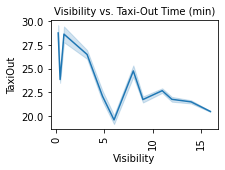

In [18]:
#Figure 11- Queue Score vs Taxi Out
fig, ax = plt.subplots(figsize=(3,2)) 
sns.lineplot(x='Visibility', y='TaxiOut', data=atlanta_outliers_removed)
plt.xticks(rotation=90);
plt.title("Visibility vs. Taxi-Out Time (min)", size=10);

In [19]:
#FEATURE SELECTION-FILTERING
#Correlation with output variable
cor_target = abs(cor["TaxiOut"])
#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.1]
#relevant_features # Since only humidity and visibility have correlations meanningful correlation we will keep them
#P.S. Month will be categorical

In [20]:
atlanta_select_features = atlanta_outliers_removed.drop(['Temperature', 'Pressure', 'Wind'], axis=1)

In [21]:
#Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
atlanta_standardized= atlanta_taxiout_tagged.copy()
atlanta_standardized[['QueueScores','TaxiOut','Humidity', 'Visibility']] = scaler.fit_transform(atlanta_standardized[['QueueScores','TaxiOut','Humidity', 'Visibility']])

In [22]:
#DataFrame with only Data to use
ready_data = atlanta_time_tagging.reindex(columns=['TaxiOut', 'TaxiOutCategory', 'QueueScores', 'UniqueCarrier', 'Season', 'DayOfWeek', 'TimeCategory', 'Humidity', 'Visibility'])

In [23]:
data = pd.get_dummies(data=ready_data, columns=['UniqueCarrier', 'Season','DayOfWeek','TimeCategory'])

In [24]:
#Train and Test Data
X = data.drop(['TaxiOut','TaxiOutCategory'], axis=1)
y = data['TaxiOutCategory'].values

from sklearn.model_selection import train_test_split
#Test and train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)
#Train and Validation Data
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=101)

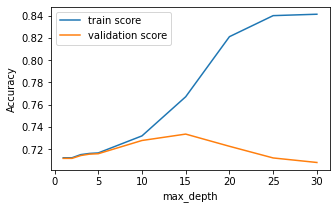

In [27]:
#Figure 13 Random Forest max_depth tuning
from sklearn.ensemble import RandomForestClassifier
param_range = [1,2,3,4,5,10,15,20,25,30]
train_score = []
valid_score = []
for max_depth in param_range:
    rf = RandomForestClassifier(max_depth=max_depth, random_state=1)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    valid_score.append(rf.score(X_valid, y_valid))
plt.figure(figsize=(5,3))
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.plot(param_range, train_score, label="train score")
plt.plot(param_range, valid_score, label="validation score")
plt.legend()
plt.show()

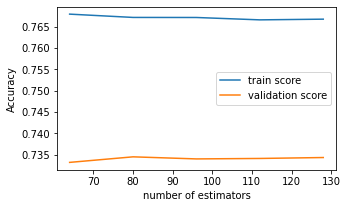

In [28]:
#Figure 14 Random Forest n_estimators tuning
param_range = [64, 80, 96, 112, 128]
train_score = []
valid_score = []
for estimator in param_range:
    rf = RandomForestClassifier(n_estimators = estimator,  max_depth = 15, random_state=1)
    rf.fit(X_train, y_train)
    train_score.append(rf.score(X_train, y_train))
    valid_score.append(rf.score(X_valid, y_valid))
plt.figure(figsize=(5,3))
plt.xlabel('number of estimators')
plt.ylabel('Accuracy')
plt.plot(param_range, train_score, label="train score")
plt.plot(param_range, valid_score, label="validation score")
plt.legend()
plt.show()  

In [29]:
# Figure 15, Logistic Regression Hyperparameter test (This code runs for approximately 20-30 minutes)
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
model = LogisticRegression(max_iter = 1000)
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.724096 using {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.723996 (0.002163) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.724055 (0.002194) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.724010 (0.002178) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.724005 (0.002179) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.724041 (0.002273) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.723987 (0.002203) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.723992 (0.002192) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.724032 (0.002258) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.724032 (0.002195) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.724028 (0.002263) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.724096 (0.002243) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.724096 (0.002226) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.723535 (0.002198) with: {

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


0.8592742726497458 0.6593549963790588


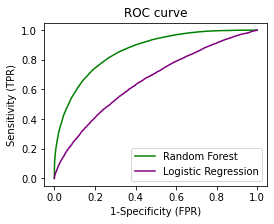

In [30]:
#Figure 16 Random Forest and Logistic Regression Comparison
# predict probabilities
rf = RandomForestClassifier(max_depth = 15, random_state=1)
rf.fit(X_test, y_test)
logistic =  LogisticRegression(C = 0.1, penalty = 'l2', solver='lbfgs', max_iter = 1000)
logistic.fit(X_test, y_test)
pred_prob1 = rf.predict_proba(X_test)
pred_prob2 = logistic.predict_proba(X_test)
from sklearn.metrics import roc_curve
# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label='Normal')
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label='Normal')
# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)
from sklearn.metrics import roc_auc_score
# auc scores
auc_score1 = roc_auc_score(y_test, pred_prob1[:,1])
auc_score2 = roc_auc_score(y_test, pred_prob2[:,1])
print(auc_score1, auc_score2)
# plot roc curves
plt.figure(figsize=(4,3))
plt.plot(fpr1, tpr1, linestyle='-',color='green', label='Random Forest')
plt.plot(fpr2, tpr2, linestyle='-',color='purple', label='Logistic Regression')
plt.plot(p_fpr, p_tpr, linestyle='-', color='blue')
plt.title('ROC curve')
plt.xlabel('1-Specificity (FPR)')
plt.ylabel('Sensitivity (TPR)')
plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [31]:
#Random Forest Performance Evaluation
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score as f1
from sklearn.metrics import confusion_matrix as cm
rf = RandomForestClassifier(max_depth=15, random_state=1)
rf.fit(X_test, y_test)
prediction = rf.predict(X_test)
print("Recall: "+str(recall(y_test,prediction, pos_label='Normal')))
print("Precision: "+str(precision(y_test,prediction, pos_label='Normal')))
print("F1 score: "+str(f1(y_test,prediction, pos_label='Normal')))
print("Confusion matrix: \n"+str(cm(y_test,prediction)))
print("Accuracy:" ,rf.score(X_test, y_test))

Recall: 0.2970235998591053
Precision: 0.8606787445776984
F1 score: 0.44163666121112927
Confusion matrix: 
[[27576   546]
 [ 7983  3373]]
Accuracy: 0.7839556208521201


In [32]:
#Cross Validation Random Forest
from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf, X_test, y_test, cv=5)
print('Accuracy scores: '+str(scores))

Accuracy scores: [0.72226444 0.72783688 0.72733029 0.7251425  0.73096897]


In [33]:
#Logistic Regression Performance Evaluation
logistic= LogisticRegression(C= 100, penalty= 'l2', solver= 'liblinear' )
logistic.fit(X_test, y_test)
prediction = logistic.predict(X_test)
print("Recall: "+str(recall(y_test,prediction, pos_label='Normal')))
print("Precision: "+str(precision(y_test,prediction, pos_label='Normal')))
print("F1 score: "+str(f1(y_test,prediction, pos_label='Normal')))
print("Confusion matrix: \n"+str(cm(y_test,prediction)))
print("Accuracy:" ,logistic.score(X_test, y_test))

Recall: 0.12328284607256076
Precision: 0.5904681568958245
F1 score: 0.2039775624681285
Confusion matrix: 
[[27151   971]
 [ 9956  1400]]
Accuracy: 0.7232129287197933
